Trying out Pymc3 HMC on a simple Beta Bernoulli model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
import jax
import jax.numpy as jnp
from jax import lax
from tensorflow_probability.substrates import jax as tfp

import seaborn as sns

In [3]:
key = jax.random.PRNGKey(127)
dataset = np.zeros(8)
n_samples = len(dataset)
print(f"Dataset: {dataset}")
n_heads = dataset.sum()
n_tails = n_samples - n_heads

Dataset: [0. 0. 0. 0. 0. 0. 0. 0.]


In [4]:
dist = tfp.distributions

def prior_dist():
    return dist.Beta(concentration1=2.0, concentration0=2.0)

def likelihood_dist(theta):
    return dist.Bernoulli(probs=theta)

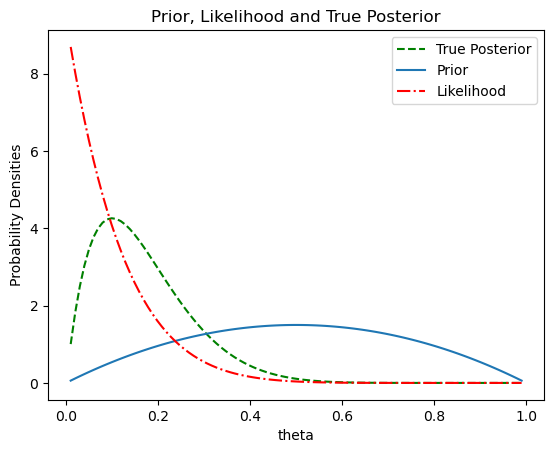

In [5]:
# closed form of beta posterior
a = prior_dist().concentration1
b = prior_dist().concentration0

exact_posterior = dist.Beta(concentration1=a + n_heads, concentration0=b + n_tails)

theta_range = jnp.linspace(0.01, 0.99, 100)

fig, ax = plt.subplots()
ax.plot(theta_range, exact_posterior.prob(theta_range), "g--", label="True Posterior")
ax.plot(theta_range, prior_dist().prob(theta_range), label="Prior")

likelihood = jax.vmap(lambda x: jnp.prod(likelihood_dist(x).prob(dataset)))(theta_range)
likelihood = likelihood / (likelihood.sum()*(theta_range[1]-theta_range[0]))
ax.plot(theta_range, likelihood, "r-.", label="Likelihood")

ax.set_title("Prior, Likelihood and True Posterior")
ax.set_xlabel("theta")
ax.set_ylabel("Likelihood")
ax.set_ylabel("Probability Densities")
ax.legend()
plt.show()

In [7]:
import time
import numpy.random as npr
npr.seed(0)
start_time_hmc = time.time()

with pm.Model() as model:
    # Prior: Beta(2, 2)
    theta = pm.Beta("theta", alpha=2, beta=2)
    
    # Likelihood: Bernoulli likelihood
    y = pm.Bernoulli("y", p=theta, observed=dataset)
    
    # Using HMC to sample from the posterior
    # Here 2000 is the number of samples and 1000 is the number of tuning steps
    trace = pm.sample(2000, tune=1000, cores=4)

end_time_hmc = time.time()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 16 seconds.


In [27]:
print(f"Time taken to execute the cell: {end_time_hmc - start_time_hmc} seconds")

Time taken to execute the cell: 20.987120151519775 seconds


In [28]:
trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [29]:
thetas = jnp.array(trace.posterior["theta"])#.flatten()
thetas.shape
# 4 chains of 2000 samples each

(4, 2000)

In [30]:
theta1 = thetas[0, :]
theta1.shape

(2000,)

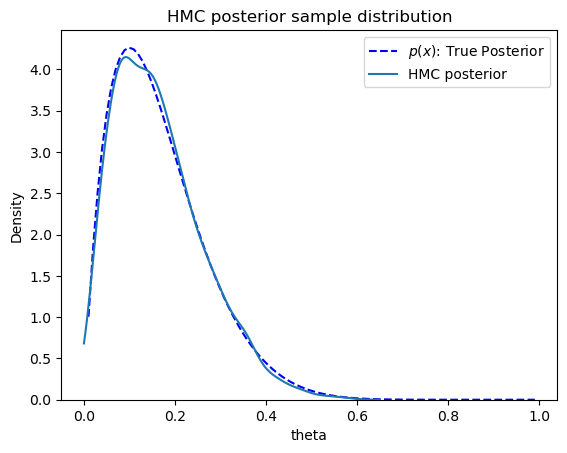

In [31]:
import warnings
warnings.filterwarnings("ignore")

plt.title("HMC posterior sample distribution")
plt.plot(theta_range, exact_posterior.prob(theta_range), "b--", label="$p(x)$: True Posterior")
sns.kdeplot(theta1, label="HMC posterior", clip=(0.0, 1.0)) #, bw_adjust=1)
plt.xlabel("theta")
plt.legend()

In [32]:
thetas.reshape(2000,4).shape

(2000, 4)

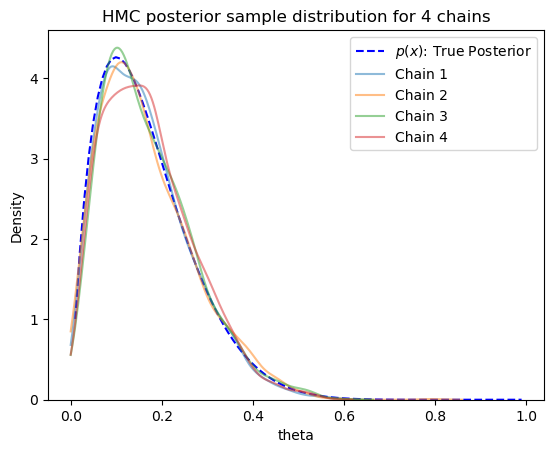

In [33]:
import warnings
warnings.filterwarnings("ignore")

plt.title("HMC posterior sample distribution for 4 chains")
plt.plot(theta_range, exact_posterior.prob(theta_range), "b--", label="$p(x)$: True Posterior")
for i in range(1, 5):
    sns.kdeplot(thetas[i-1, :], label=f"Chain {i}", clip=(0.0, 1.0), alpha = 0.5) #, bw_adjust=1)
# sns.kdeplot(thetas.reshape(2000,4), label="HMC posterior", clip=(0.0, 1.0)) #, bw_adjust=1)
plt.xlabel("theta")
plt.legend()

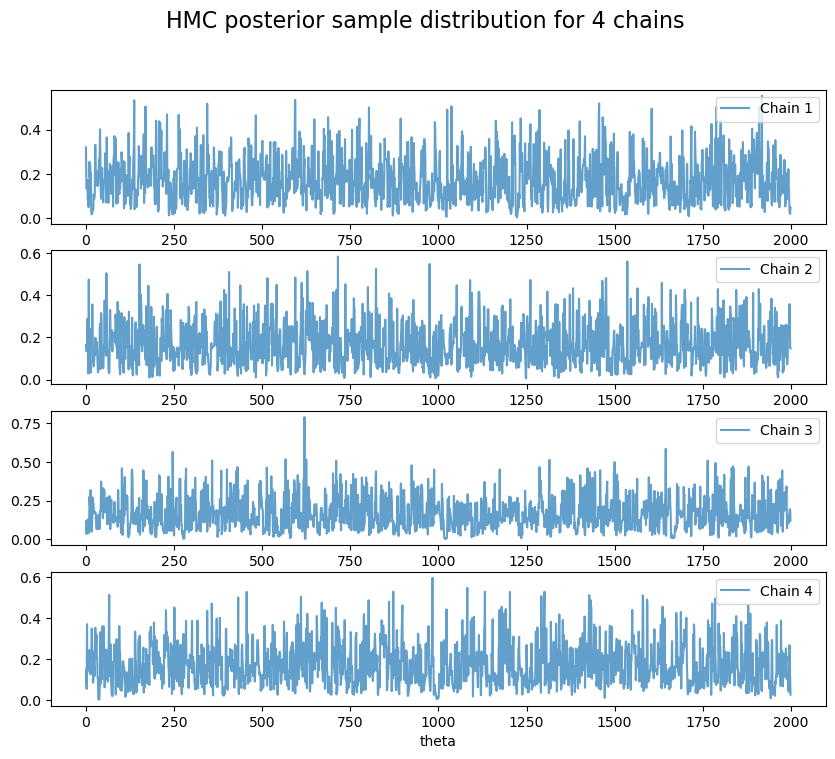

In [34]:
# Visulaising outputs of the 4 chains
fig, ax = plt.subplots(4,1, figsize=(10, 8))
fig.suptitle("HMC posterior sample distribution for 4 chains", fontsize=16)
# plt.title("HMC posterior sample distribution for 4 chains")
for i in range(4):
    ax[i].plot(thetas[i-1, :], label = f"Chain {i+1}", alpha = 0.7)
    ax[i].set_xlabel("theta")
    ax[i].legend()
plt.show()


### ADVI

In [37]:
start_time_advi = time.time()
with pm.Model() as advi_model:
    # Prior: Beta(2, 2)
    theta = pm.Beta("theta", 2, 2)

    # Model likelihood: Bernoulli
    y = pm.Bernoulli("y", p=theta, observed=dataset)  # Bernoulli

    # Creating an ADVI instance
    advi = pm.ADVI()

    # Tracks the mean and std during training
    tracker = pm.callbacks.Tracker(
        mean=advi.approx.mean.eval,  
        std=advi.approx.std.eval,  
    )

    # Performing the ADVI optimization
    # Here approx is an instance of Approximation class, n is the number of iterations
    approx = advi.fit(callbacks=[tracker], n=20000)

# Draw samples from the approximated posterior
trace_approx = approx.sample(1000)

end_time_advi = time.time()

Finished [100%]: Average Loss = 2.9556


In [38]:
print(f"Time taken to execute the cell: {end_time_advi - start_time_advi} seconds")

Time taken to execute the cell: 1.7812979221343994 seconds


In [39]:
type(trace_approx)

arviz.data.inference_data.InferenceData

In [40]:
thetas = jnp.array(trace_approx.posterior["theta"]).flatten()
thetas.shape

(1000,)

In [41]:
type(advi)

pymc.variational.inference.ADVI

In [42]:
type(advi.hist)

numpy.ndarray

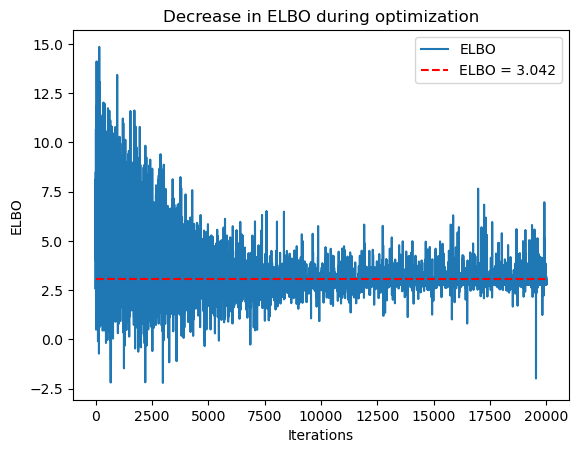

In [47]:
plt.plot(advi.hist, label="ELBO")
plt.title("Decrease in ELBO during optimization")

plt.hlines(y=advi.hist[-1], xmin=0, xmax=len(advi.hist), color = "r", linestyles= "--", 
           label=f"ELBO = {advi.hist[-1]:.3f}")
plt.xlabel("Iterations")
plt.ylabel("ELBO")
plt.legend()
# plt.savefig("advi_beta_binom_pymc_loss.pdf")
plt.show()

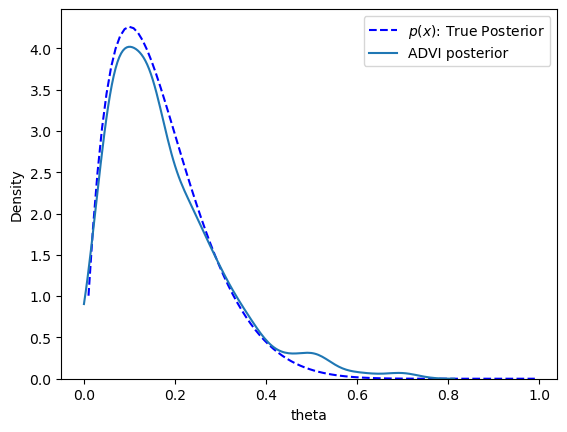

In [48]:
import warnings
warnings.filterwarnings("ignore")

plt.plot(theta_range, exact_posterior.prob(theta_range), "b--", label="$p(x)$: True Posterior")
sns.kdeplot(thetas, label="ADVI posterior", clip=(0.0, 1.0)) #, bw_adjust=1)
plt.xlabel("theta")
plt.legend()
# plt.legend(bbox_to_anchor=(1.3, 1))

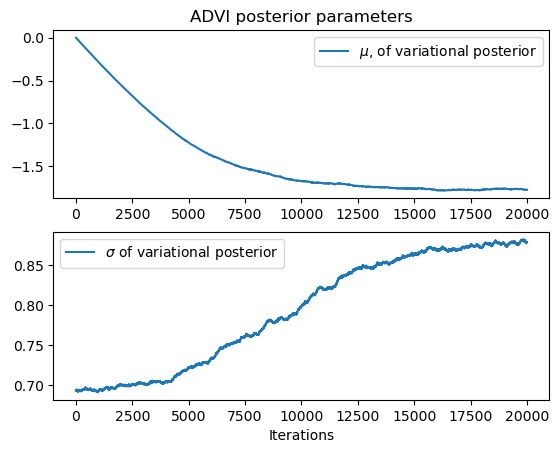

In [49]:
fig, ax = plt.subplots(2,1)
ax[0].set_title("ADVI posterior parameters")
ax[0].plot(tracker["mean"], label="$\mu$, of variational posterior")
ax[0].legend()
# sns.despine()

# pymc
# fig, ax4 = plt.subplots()
ax[1].plot(tracker["std"], label="$\sigma$ of variational posterior")
ax[1].set_xlabel("Iterations")
ax[1].legend()